<a href="https://colab.research.google.com/github/mashaan14/YouTube-channel/blob/main/notebooks/2024_05_27_GNN_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Visual Guide to GNN Sampling using PyTorch Geometric

## YouTube:
I explained this notebook in a [YouTube video](https://youtu.be/y0poBC8xN1k).

## Acknowledgment:
I borrowed some code from [pytorch-geometric tutorials](https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html)

## References:
```bibtex
@inproceedings{Fey/Lenssen/2019,
  title={Fast Graph Representation Learning with {PyTorch Geometric}},
  author={Fey, Matthias and Lenssen, Jan E.},
  booktitle={ICLR Workshop on Representation Learning on Graphs and Manifolds},
  year={2019},
}
```

## Install Dependencies

In [ ]:
# install pytorch_geometric
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


If you're using a CPU, check torch version:

`!python -c "import torch; print(torch.__version__)"`

the command to install the dpendencies:

`!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.2.1+cpu.html`

---

If you're using a GPU, check torch version:

`!python -c "import torch; print(torch.__version__)"`

and CUDA version:

`!python -c "import torch; print(torch.version.cuda)"`

the command to install the dpendencies:

`!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.2.1+cu121.html`

In [ ]:
!python -c "import torch; print(torch.__version__)"

2.2.1+cu121


In [ ]:
!python -c "import torch; print(torch.version.cuda)"

12.1


In [ ]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.2.1+cpu.html

Looking in links: https://data.pyg.org/whl/torch-2.2.1+cpu.html


## Import libraries

In [ ]:
# Standard libraries
import numpy as np
from scipy import sparse
import seaborn as sns
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import cm
from IPython.display import Javascript  # Restrict height of output cell.

# PyTorch
import torch
import torch.nn.functional as F
from torch.nn import Linear

# import pyg_lib
import torch_sparse

# PyTorch geometric
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.datasets import StochasticBlockModelDataset
from torch_geometric.utils import to_networkx
from torch_geometric.loader import ClusterData, ClusterLoader, NeighborLoader
from torch_geometric.loader import GraphSAINTNodeSampler, GraphSAINTEdgeSampler, GraphSAINTRandomWalkSampler
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.data import Data
from torch_geometric import seed_everything

In [ ]:
random_seed = 42
torch.manual_seed(1234567)
seed_everything(42)
plt.style.use('dark_background')

In [ ]:
num_nodes_per_class = 500
num_nodes = [num_nodes_per_class] * 3
edge_probs = [[0.1, 0.05, 0.02],
              [0.05, 0.1, 0.02],
              [0.02, 0.02, 0.1]]
dataset = StochasticBlockModelDataset('/content', num_nodes, edge_probs, num_channels=10)

In [ ]:
colors = cm.tab10.colors
y_colors = np.array(colors)[dataset[0].y.numpy()]

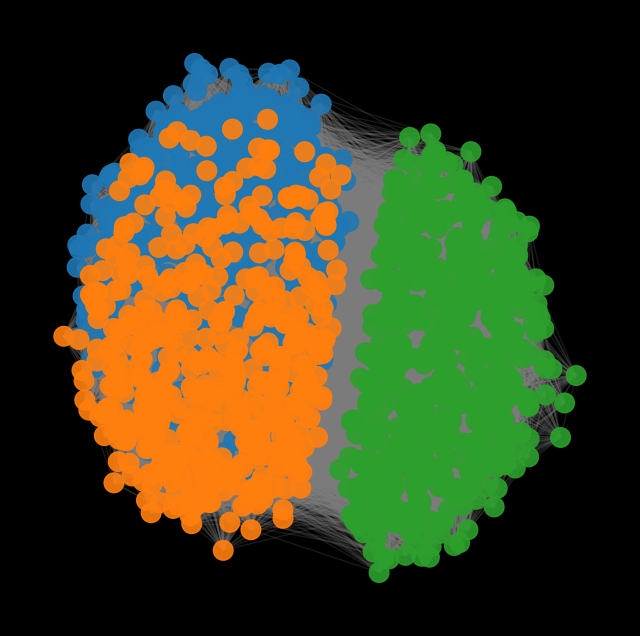

In [ ]:
G = to_networkx(dataset[0], to_undirected=True)
node_pos=nx.spring_layout(G, seed=0)
plt.figure(figsize=(8,8))
plt.axis('off')
nx.draw_networkx_nodes(G,
                pos=node_pos,
                node_size=200,
                node_color=y_colors,
                alpha=0.9
                )
nx.draw_networkx_edges(G,
                pos=node_pos,
                edge_color="grey",
                alpha=0.2
                )
plt.show()

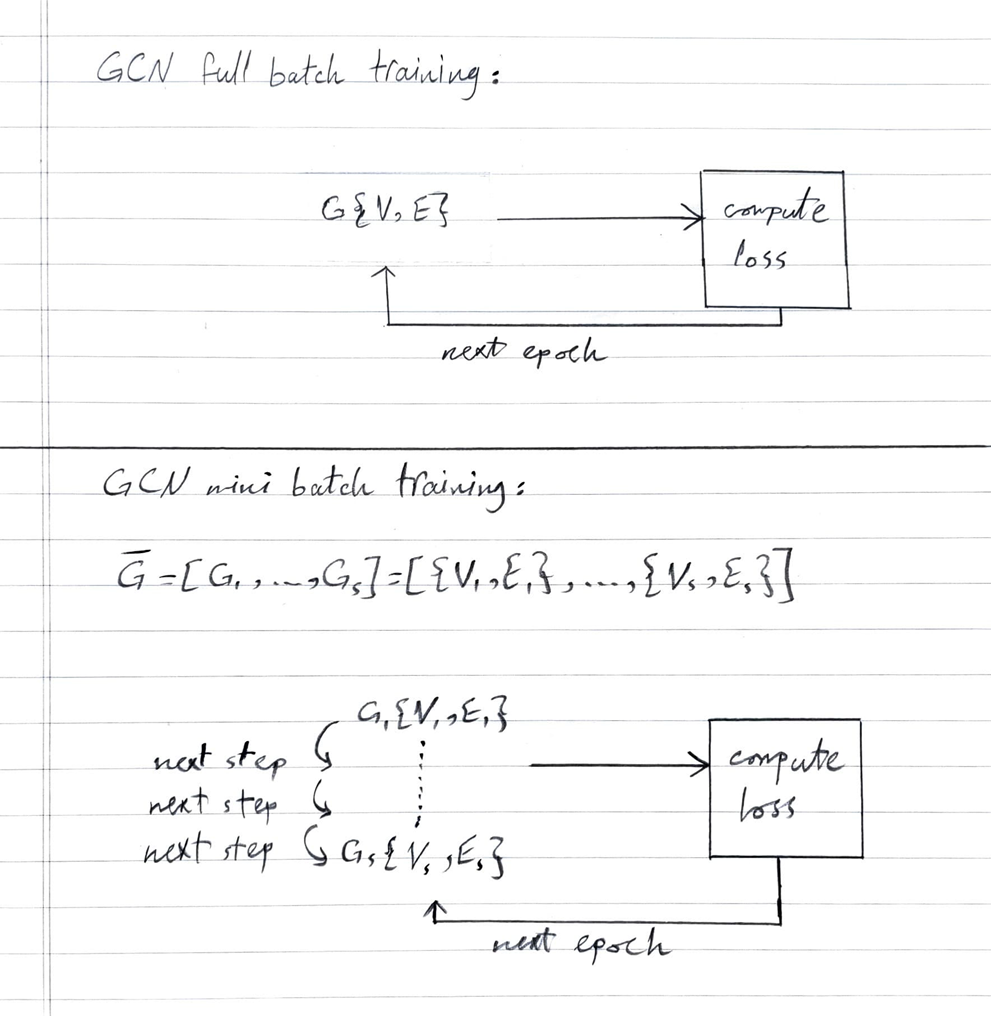

## `NeighborLoader`

`NeighborLoader` produces subgraphs $G_s$ sampled from the original graph $G$. The number of subgraphs is determined by:
- batch size: the number of seed nodes (first nodes in the batch)
- the number of nodes in $G$

$\text{number of subgraphs} = \frac{\text{number of nodes}}{\text{batch size (the number of seed nodes)}}$

In [ ]:
BATCH_SIZE = 128
loader_neighbor_128 = NeighborLoader(dataset[0], num_neighbors=[10, 10], batch_size=BATCH_SIZE)
print(f'number of nodes / batch size:         {dataset[0].x.shape[0]} / {BATCH_SIZE} = {dataset[0].x.shape[0]/BATCH_SIZE}')

number of nodes / batch size:         1500 / 128 = 11.71875


This `NeighborLoader` has 12 subgraphs.

In [ ]:
for i, s in enumerate(loader_neighbor_128):
  print(f'Subgraph: {i:02d}, feature matrix: {s.x.shape}, edges list: {s.edge_index.shape}')

Subgraph: 00, feature matrix: torch.Size([1484, 10]), edges list: torch.Size([2, 8300])
Subgraph: 01, feature matrix: torch.Size([1490, 10]), edges list: torch.Size([2, 8350])
Subgraph: 02, feature matrix: torch.Size([1483, 10]), edges list: torch.Size([2, 8240])
Subgraph: 03, feature matrix: torch.Size([1483, 10]), edges list: torch.Size([2, 8430])
Subgraph: 04, feature matrix: torch.Size([1480, 10]), edges list: torch.Size([2, 8140])
Subgraph: 05, feature matrix: torch.Size([1489, 10]), edges list: torch.Size([2, 8210])
Subgraph: 06, feature matrix: torch.Size([1483, 10]), edges list: torch.Size([2, 8180])
Subgraph: 07, feature matrix: torch.Size([1495, 10]), edges list: torch.Size([2, 8760])
Subgraph: 08, feature matrix: torch.Size([1478, 10]), edges list: torch.Size([2, 7420])
Subgraph: 09, feature matrix: torch.Size([1478, 10]), edges list: torch.Size([2, 7500])
Subgraph: 10, feature matrix: torch.Size([1485, 10]), edges list: torch.Size([2, 7560])
Subgraph: 11, feature matrix: to

Let's plot the first 3 subgraphs. Nodes in white indicate that these nodes were not sampled in this subgraph.

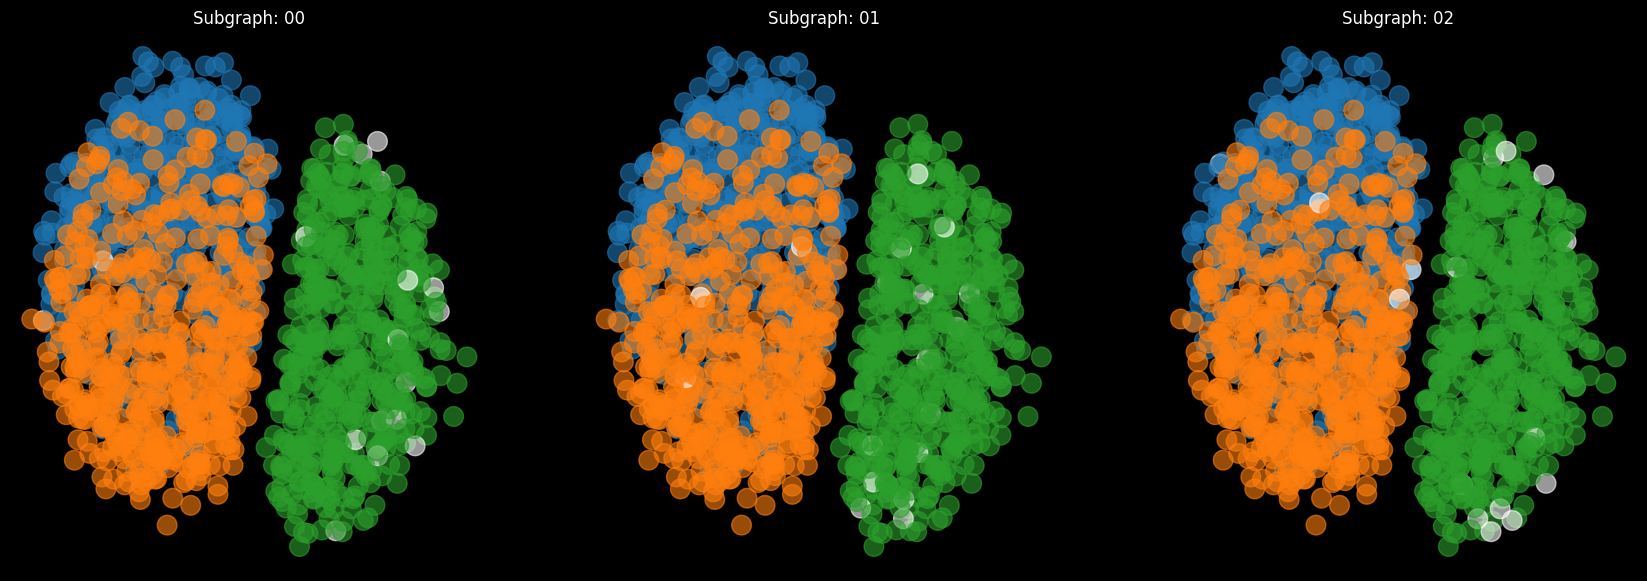

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(21, 7))
axs = axs.flatten()
for i in range(3):
  s = next(iter(loader_neighbor_128))
  # create an array to color all nodes in white
  sampled_graph_color = np.ones_like(y_colors)
  # use label colors for the nodes in this subgraph
  # and keep everything else in white
  sampled_graph_color[s.n_id] = y_colors[s.n_id]

  axs[i].axis('off')
  axs[i].set_title(f'Subgraph: {i:02d}')
  nx.draw_networkx_nodes(G,
                  pos=node_pos,
                  node_size=200,
                  node_color=sampled_graph_color,
                  alpha=0.6,
                  ax = axs[i]
                  )

plt.show()

### Balancing the tradeoff between batch size and number of subgraphs:
Setting the batch size to a small number increases the number of subgraphs. But each subgraph would have a smaller number of nodes because we are sampling from a smaller subset of seed nodes. Selecting a large number for the batch size leads to a smaller number of subgraphs each of which has more nodes because we are sampling from a larger subset of seed nodes.

In [ ]:
BATCH_SIZE = 32
loader_neighbor_32 = NeighborLoader(dataset[0], num_neighbors=[10, 10], batch_size=BATCH_SIZE)
print(f'number of nodes / batch size:         {dataset[0].x.shape[0]} / {BATCH_SIZE} = {dataset[0].x.shape[0]/BATCH_SIZE}')

number of nodes / batch size:         1500 / 32 = 46.875


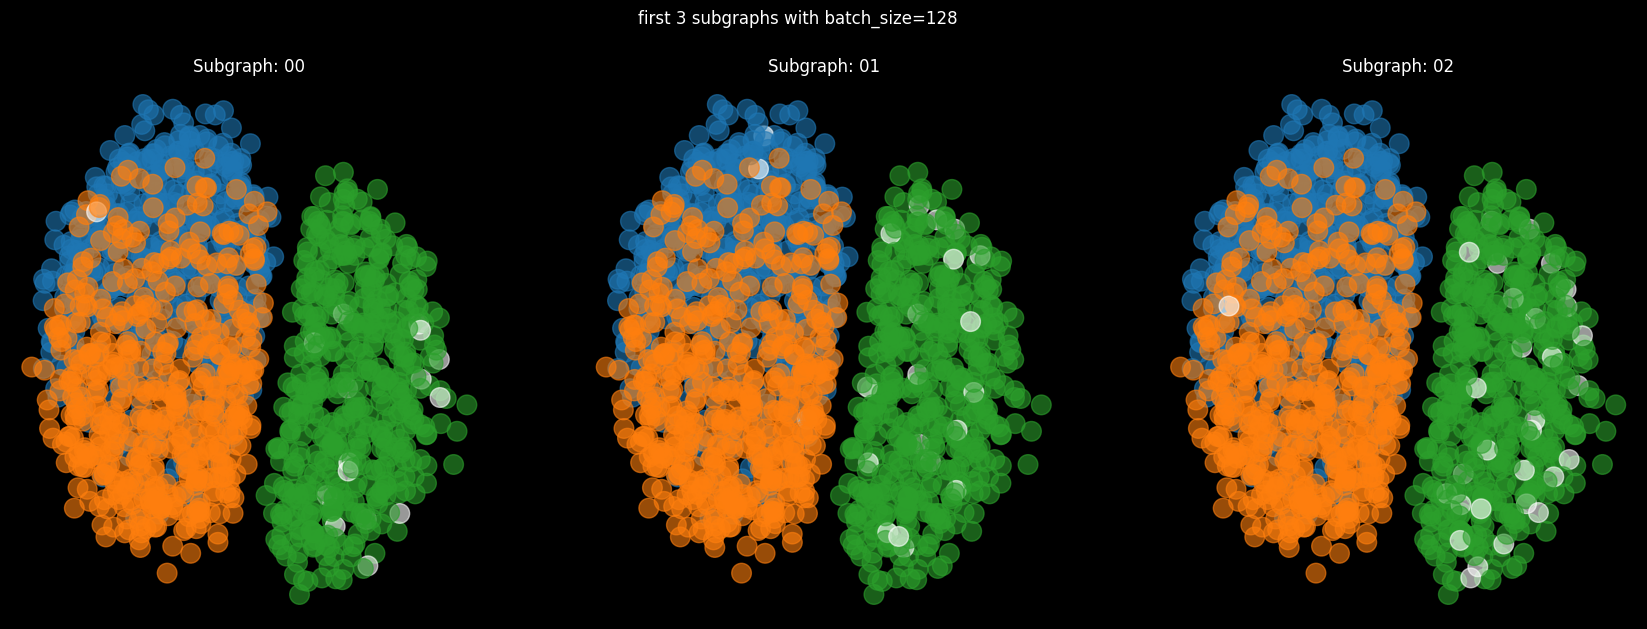

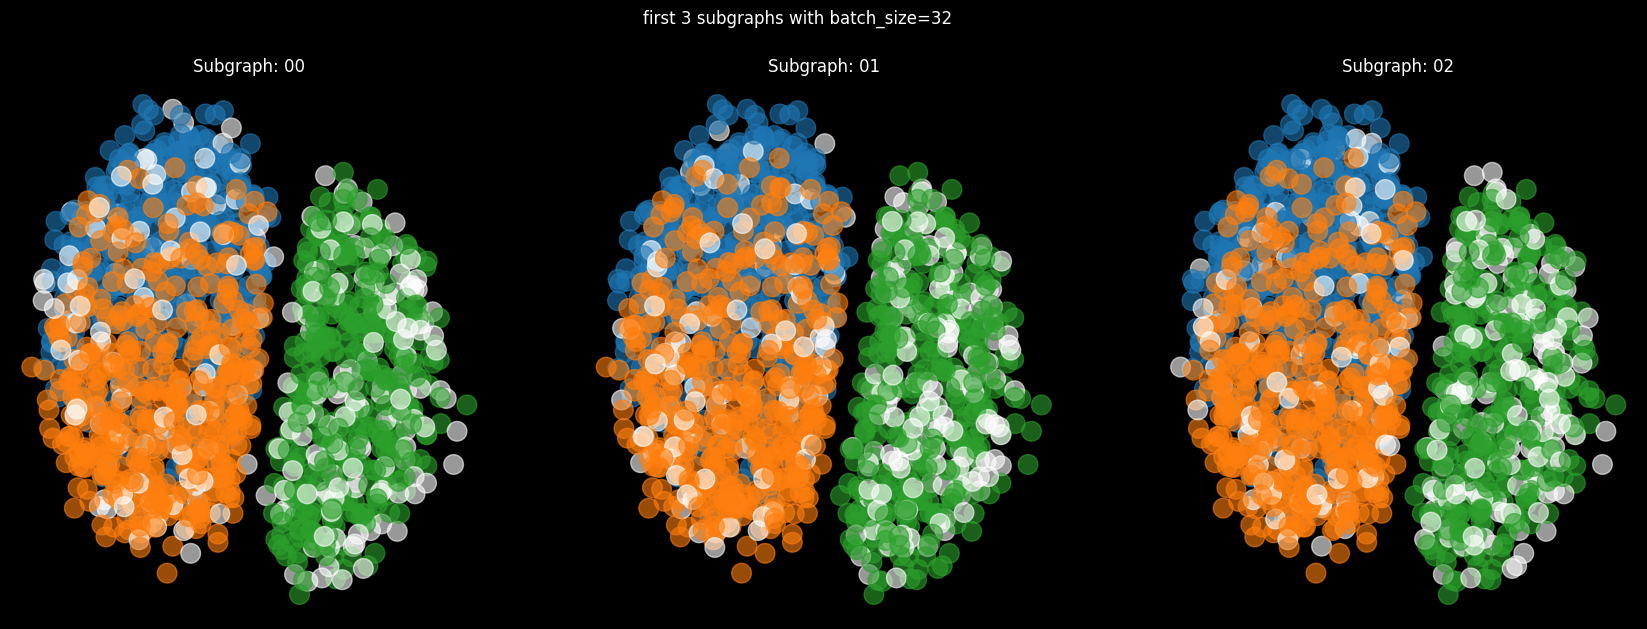

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(21, 7))
axs = axs.flatten()
for i in range(3):
  s = next(iter(loader_neighbor_128))
  # create an array to color all nodes in white
  sampled_graph_color = np.ones_like(y_colors)
  # use label colors for the nodes in this subgraph
  # and keep everything else in white
  sampled_graph_color[s.n_id] = y_colors[s.n_id]

  axs[i].axis('off')
  axs[i].set_title(f'Subgraph: {i:02d}')
  nx.draw_networkx_nodes(G,
                  pos=node_pos,
                  node_size=200,
                  node_color=sampled_graph_color,
                  alpha=0.6,
                  ax = axs[i]
                  )

plt.suptitle('first 3 subgraphs with batch_size=128')
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(21, 7))
axs = axs.flatten()
for i in range(3):
  s = next(iter(loader_neighbor_32))
  # create an array to color all nodes in white
  sampled_graph_color = np.ones_like(y_colors)
  # use label colors for the nodes in this subgraph
  # and keep everything else in white
  sampled_graph_color[s.n_id] = y_colors[s.n_id]

  axs[i].axis('off')
  axs[i].set_title(f'Subgraph: {i:02d}')
  nx.draw_networkx_nodes(G,
                  pos=node_pos,
                  node_size=200,
                  node_color=sampled_graph_color,
                  alpha=0.6,
                  ax = axs[i]
                  )

plt.suptitle('first 3 subgraphs with batch_size=32')
plt.show()

## `ClusterLoader`

In `ClusterLoader` the graph is partitioned using $METIS$ algorithm into the number of partitioned specified in the parameter `num_parts`. Then, these partitions are grouped into batches where each batch contains partitions specified in `batch_size` parameter. The number of subgraphs is determined by:
- the number of partitions: `num_parts` parameter
- the batch size: `batch_size` parameter

$\text{number of subgraphs} = \frac{\text{total number of partitions}}{\text{batch size (number of partitions in each batch)}}$

In [ ]:
NUM_PARTS = 128
BATCH_SIZE = 32
cluster_data = ClusterData(dataset[0], num_parts=NUM_PARTS)
loader_cluster_128_32 = ClusterLoader(cluster_data, batch_size=32, shuffle=True)

Computing METIS partitioning...
Done!


In [ ]:
print(f'number of partitions / batch size:         {NUM_PARTS} / {BATCH_SIZE} = {NUM_PARTS/BATCH_SIZE}')

number of nodes / batch size:         128 / 32 = 4.0


This `ClusterLoader` has 4 subgraphs. Note that these subgraphs are independent from each other. There is no overlap between these subgraphs like in `NeighborLoader`.

In [ ]:
for i, s in enumerate(loader_cluster_128_32):
  print(f'Subgraph: {i:02d}, feature matrix: {s.x.shape}, edges list: {s.edge_index.shape}')

Subgraph: 00, feature matrix: torch.Size([376, 10]), edges list: torch.Size([2, 8542])
Subgraph: 01, feature matrix: torch.Size([372, 10]), edges list: torch.Size([2, 8376])
Subgraph: 02, feature matrix: torch.Size([379, 10]), edges list: torch.Size([2, 8744])
Subgraph: 03, feature matrix: torch.Size([373, 10]), edges list: torch.Size([2, 8534])


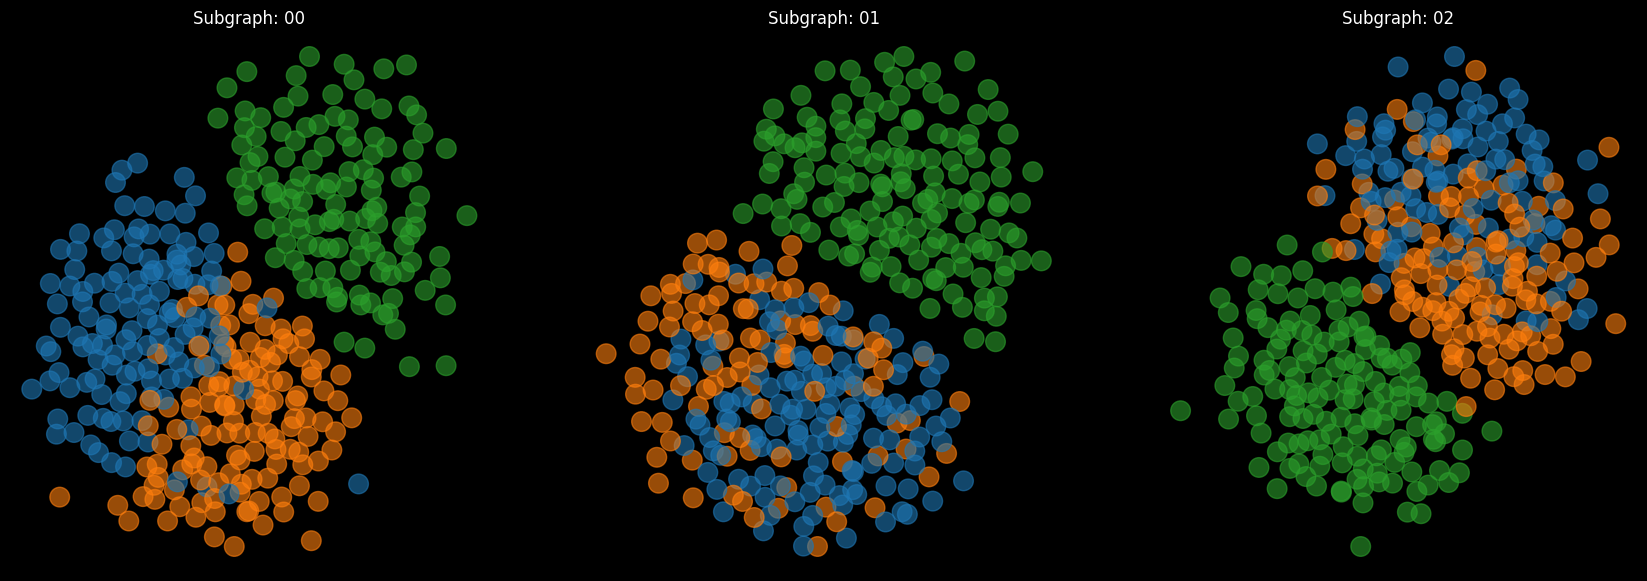

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(21, 7))
axs = axs.flatten()
for i in range(3):
  s = next(iter(loader_cluster_128_32))

  G = to_networkx(s, to_undirected=True)
  node_pos=nx.spring_layout(G, seed=0)

  axs[i].axis('off')
  axs[i].set_title(f'Subgraph: {i:02d}')
  nx.draw_networkx_nodes(G,
                  pos=node_pos,
                  node_size=200,
                  node_color=np.array(colors)[s.y.numpy()],
                  alpha=0.6,
                  ax = axs[i]
                  )

plt.show()

### Balancing the tradeoff between the number of partitions and the batch size:
Setting the number of partitions to a smaller number leads to larger clusters with more nodes. On the other hand, setting the batch size to a large number increases the number of nodes in a subgraph. But these nodes are not necessarily in the same cluster, because the batch size represents a group of clusters merged into one subgraph.

In [ ]:
NUM_PARTS = 256
BATCH_SIZE = 32
cluster_data = ClusterData(dataset[0], num_parts=NUM_PARTS)
loader_cluster_256_32 = ClusterLoader(cluster_data, batch_size=32, shuffle=True)

Computing METIS partitioning...
Done!


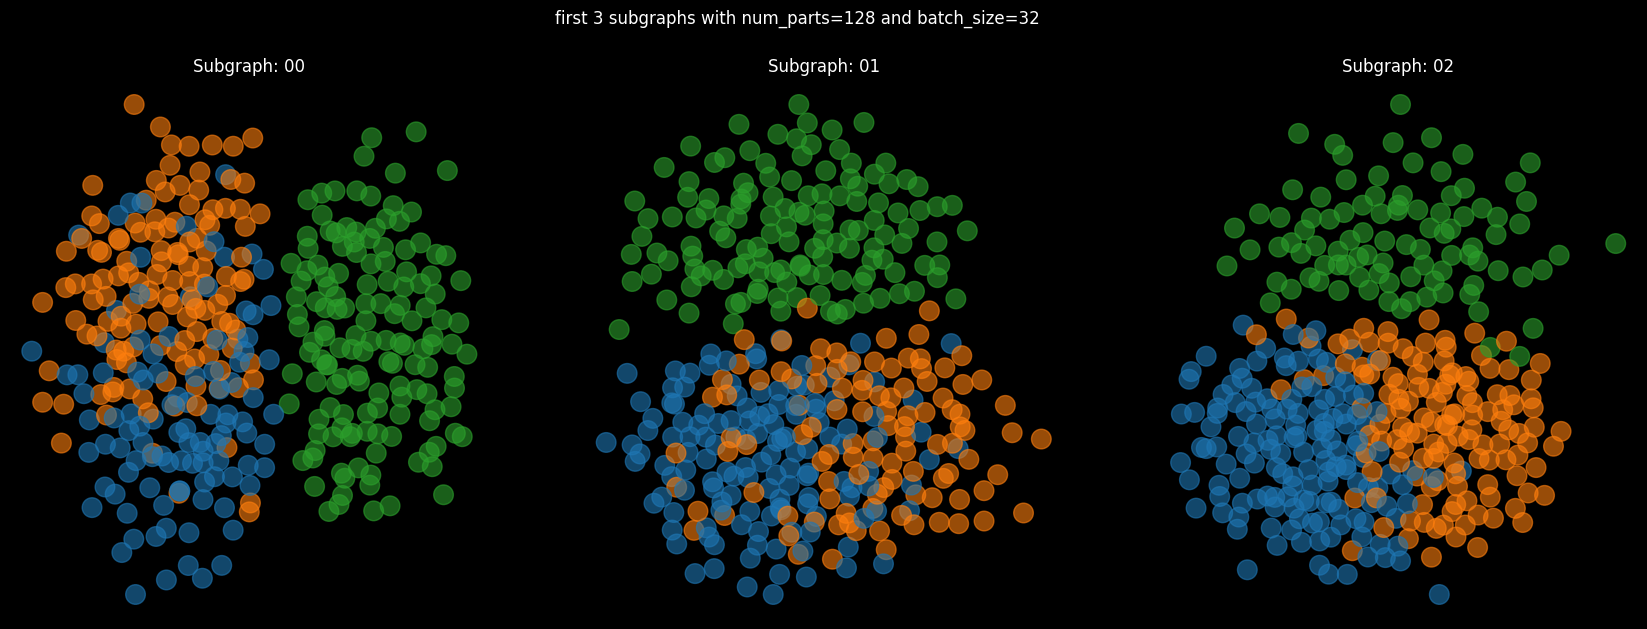

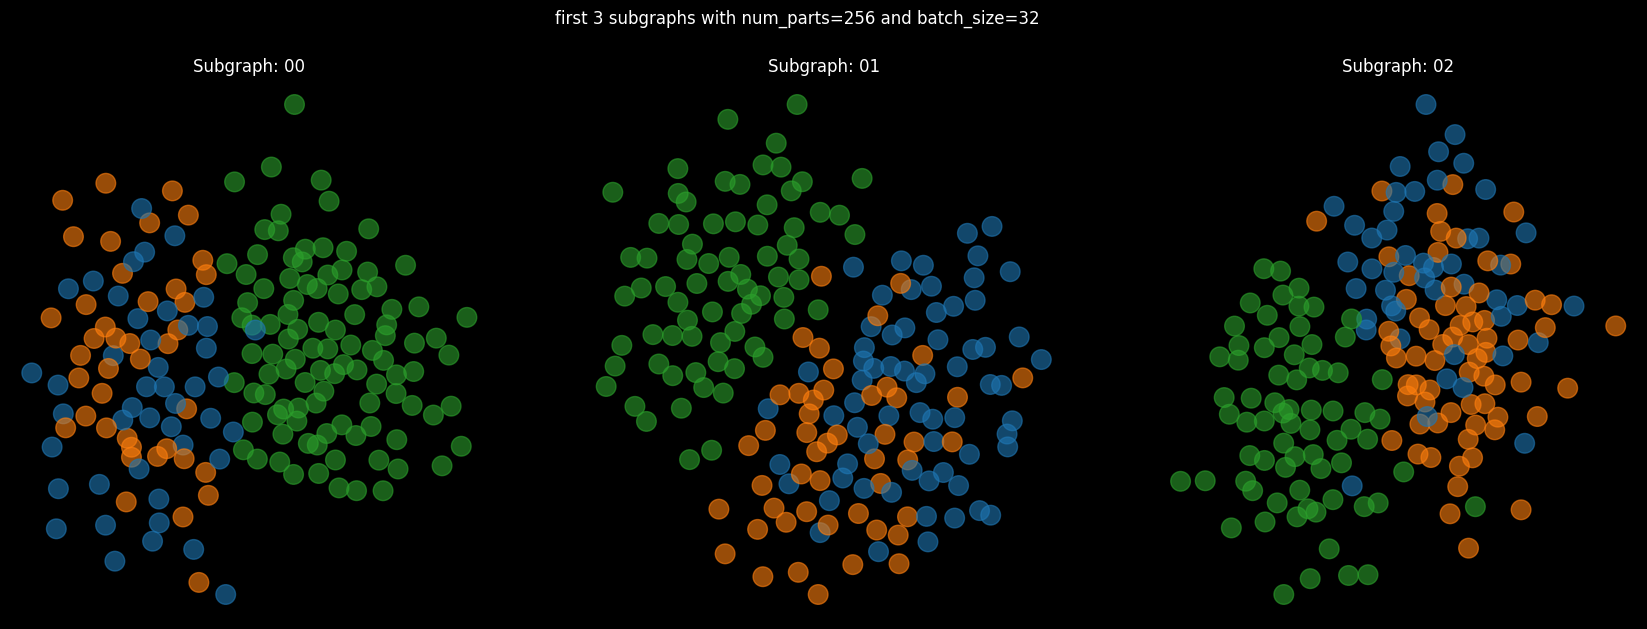

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(21, 7))
axs = axs.flatten()
for i in range(3):
  s = next(iter(loader_cluster_128_32))

  G = to_networkx(s, to_undirected=True)
  node_pos=nx.spring_layout(G, seed=0)

  axs[i].axis('off')
  axs[i].set_title(f'Subgraph: {i:02d}')
  nx.draw_networkx_nodes(G,
                  pos=node_pos,
                  node_size=200,
                  node_color=np.array(colors)[s.y.numpy()],
                  alpha=0.6,
                  ax = axs[i]
                  )

plt.suptitle('first 3 subgraphs with num_parts=128 and batch_size=32')
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(21, 7))
axs = axs.flatten()
for i in range(3):
  s = next(iter(loader_cluster_256_32))

  G = to_networkx(s, to_undirected=True)
  node_pos=nx.spring_layout(G, seed=0)

  axs[i].axis('off')
  axs[i].set_title(f'Subgraph: {i:02d}')
  nx.draw_networkx_nodes(G,
                  pos=node_pos,
                  node_size=200,
                  node_color=np.array(colors)[s.y.numpy()],
                  alpha=0.6,
                  ax = axs[i]
                  )

plt.suptitle('first 3 subgraphs with num_parts=256 and batch_size=32')
plt.show()

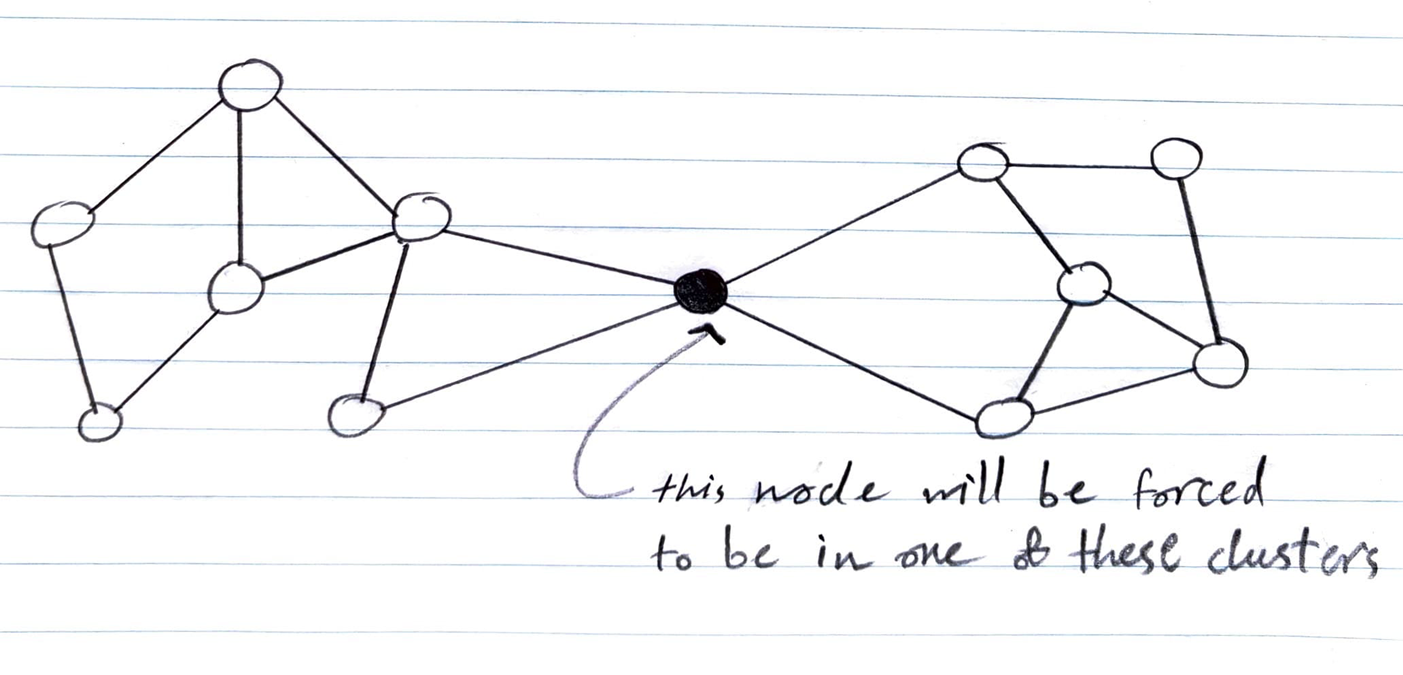

## `GraphSAINTSampler`

`GraphSAINTSampler` samples a number of subgraphs based on the number specified in the parameter `num_steps`. The `GraphSAINT` paper presented three methods of sampling:
- Random node sample
- Random edge sampler
- Random walk based samplers

$\text{number of subgraphs} = \text{num_steps parameter}$

In [ ]:
loader_SAINT_256_node = GraphSAINTNodeSampler(dataset[0], batch_size=256, num_steps=4)
loader_SAINT_256_edge = GraphSAINTEdgeSampler(dataset[0], batch_size=256, num_steps=4)
loader_SAINT_256_RW = GraphSAINTRandomWalkSampler(dataset[0], batch_size=256, walk_length=2, num_steps=4)

In [ ]:
for i, s in enumerate(loader_SAINT_256_node):
  print(f'Subgraph node sampler: {i:02d}, feature matrix: {s.x.shape}, edges list: {s.edge_index.shape}')
for i, s in enumerate(loader_SAINT_256_edge):
  print(f'Subgraph edge sampler: {i:02d}, feature matrix: {s.x.shape}, edges list: {s.edge_index.shape}')
for i, s in enumerate(loader_SAINT_256_RW):
  print(f'Subgraph RW sampler:   {i:02d}, feature matrix: {s.x.shape}, edges list: {s.edge_index.shape}')

Subgraph node sampler: 00, feature matrix: torch.Size([235, 10]), edges list: torch.Size([2, 2988])
Subgraph node sampler: 01, feature matrix: torch.Size([229, 10]), edges list: torch.Size([2, 2938])
Subgraph node sampler: 02, feature matrix: torch.Size([239, 10]), edges list: torch.Size([2, 3086])
Subgraph node sampler: 03, feature matrix: torch.Size([238, 10]), edges list: torch.Size([2, 3214])
Subgraph edge sampler: 00, feature matrix: torch.Size([429, 10]), edges list: torch.Size([2, 10582])
Subgraph edge sampler: 01, feature matrix: torch.Size([433, 10]), edges list: torch.Size([2, 11134])
Subgraph edge sampler: 02, feature matrix: torch.Size([428, 10]), edges list: torch.Size([2, 10548])
Subgraph edge sampler: 03, feature matrix: torch.Size([446, 10]), edges list: torch.Size([2, 11376])
Subgraph RW sampler:   00, feature matrix: torch.Size([602, 10]), edges list: torch.Size([2, 19842])
Subgraph RW sampler:   01, feature matrix: torch.Size([598, 10]), edges list: torch.Size([2, 19

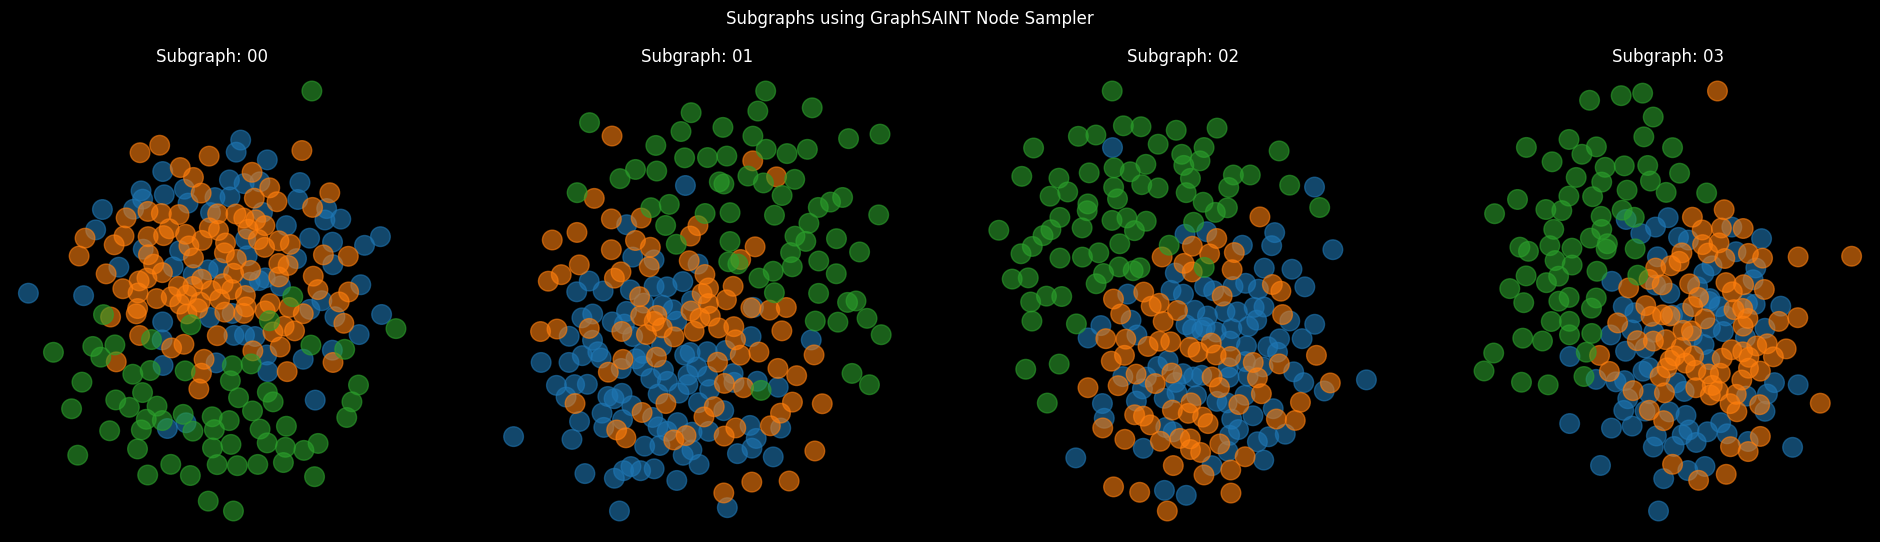

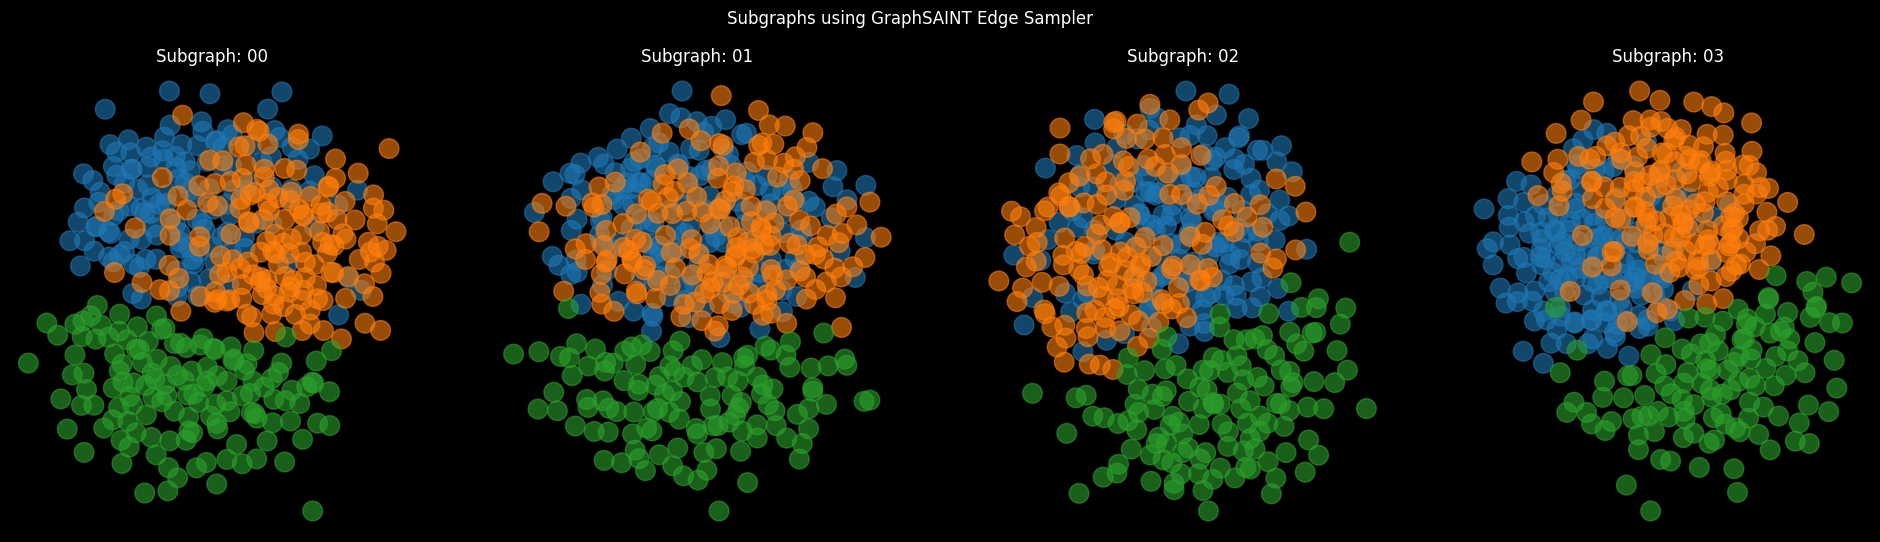

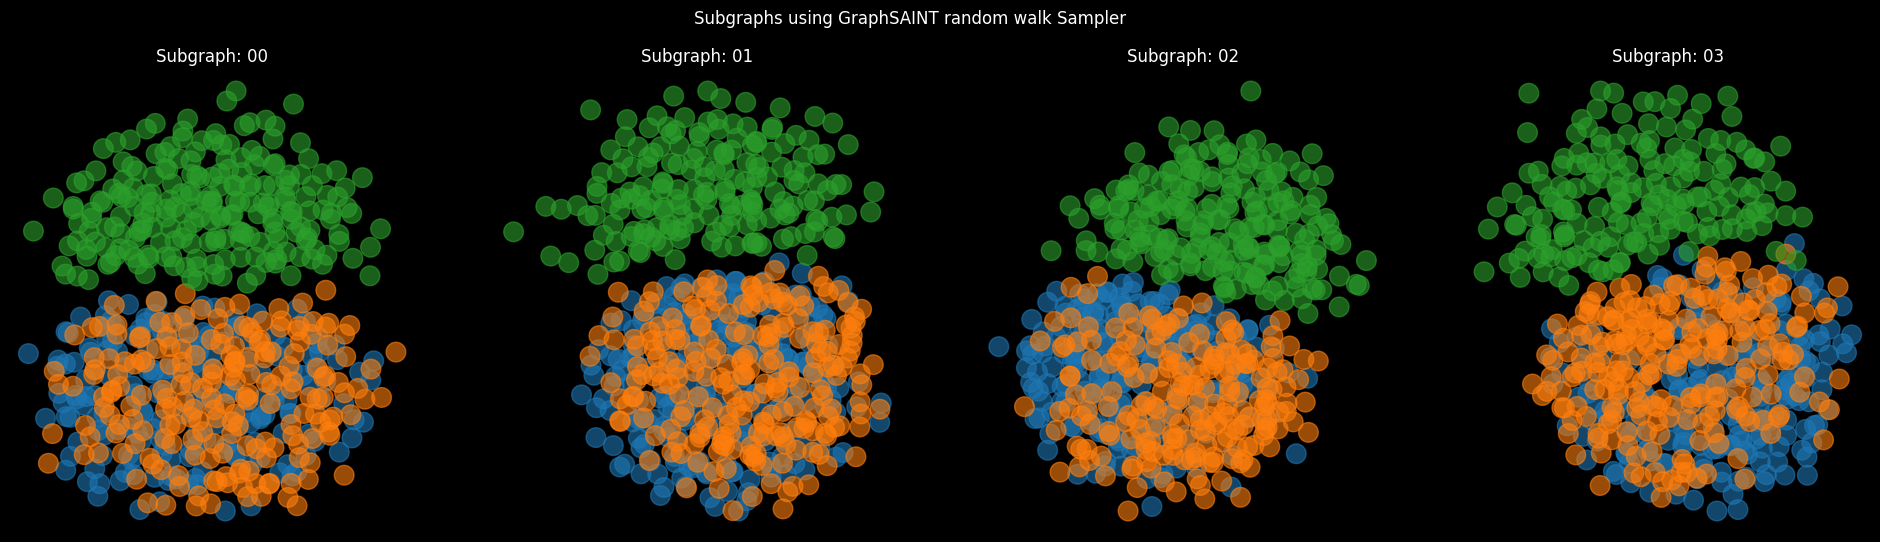

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
axs = axs.flatten()
for i in range(4):
  s = next(iter(loader_SAINT_256_node))

  G = to_networkx(s, to_undirected=True)
  node_pos=nx.spring_layout(G, seed=0)

  axs[i].axis('off')
  axs[i].set_title(f'Subgraph: {i:02d}')
  nx.draw_networkx_nodes(G,
                  pos=node_pos,
                  node_size=200,
                  node_color=np.array(colors)[s.y.numpy()],
                  alpha=0.6,
                  ax = axs[i]
                  )
plt.suptitle('Subgraphs using GraphSAINT Node Sampler')
plt.show()

fig, axs = plt.subplots(1, 4, figsize=(24, 6))
axs = axs.flatten()
for i in range(4):
  s = next(iter(loader_SAINT_256_edge))

  G = to_networkx(s, to_undirected=True)
  node_pos=nx.spring_layout(G, seed=0)

  axs[i].axis('off')
  axs[i].set_title(f'Subgraph: {i:02d}')
  nx.draw_networkx_nodes(G,
                  pos=node_pos,
                  node_size=200,
                  node_color=np.array(colors)[s.y.numpy()],
                  alpha=0.6,
                  ax = axs[i]
                  )
plt.suptitle('Subgraphs using GraphSAINT Edge Sampler')
plt.show()

fig, axs = plt.subplots(1, 4, figsize=(24, 6))
axs = axs.flatten()
for i in range(4):
  s = next(iter(loader_SAINT_256_RW))

  G = to_networkx(s, to_undirected=True)
  node_pos=nx.spring_layout(G, seed=0)

  axs[i].axis('off')
  axs[i].set_title(f'Subgraph: {i:02d}')
  nx.draw_networkx_nodes(G,
                  pos=node_pos,
                  node_size=200,
                  node_color=np.array(colors)[s.y.numpy()],
                  alpha=0.6,
                  ax = axs[i]
                  )
plt.suptitle('Subgraphs using GraphSAINT random walk Sampler')
plt.show()